In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
# Téléchargement et extraction du fichier zip
import requests, zipfile, io
zip_file_url = 'https://moncoachdata.com/wp-content/uploads/cell_images.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

## EDA sur les différentes images

In [ ]:
data_dir = "/content/cell_images"

In [ ]:
os.listdir(data_dir) # ou ! cd data_dir puis ls pour lister les sous dossiers

['train', 'test']

In [ ]:
test_path = data_dir +"/test/"
train_path = data_dir +"/train/"

In [ ]:
os.listdir(test_path), os.listdir(train_path) # nous avons encore deux sous dossier sur chaque dossier

(['uninfected', 'parasitized'], ['uninfected', 'parasitized'])

In [ ]:
os.listdir(train_path + "parasitized")[0]

'C48P9thinF_IMG_20150721_160406_cell_236.png'

In [ ]:
para_cell = train_path + "parasitized" + "/C99P60ThinF_IMG_20150918_141001_cell_136.png"

In [ ]:
imread(para_cell).shape

(151, 160, 3)

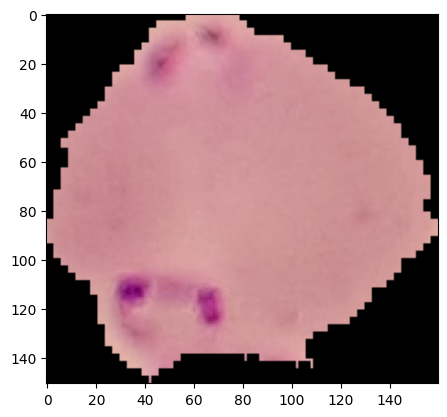

In [ ]:
plt.imshow(imread(para_cell));

In [ ]:
os.listdir(train_path + 'uninfected')[0]

'C222ThinF_IMG_20151115_151433_cell_123.png'

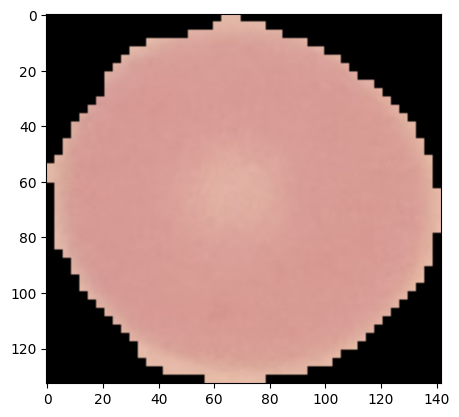

In [ ]:
uninfected_cell_path = train_path + "uninfected" + '/C104P65ThinF_IMG_20150918_171154_cell_141.png'
plt.imshow(imread(uninfected_cell_path));

In [ ]:
len(os.listdir(train_path + 'parasitized')), len(os.listdir(train_path + 'uninfected'))

(12480, 12480)

In [ ]:
len(os.listdir(test_path + 'parasitized')), len(os.listdir(test_path + 'uninfected'))

(1300, 1300)

In [ ]:
# Vérifions les dimensions de nos images
dim1 = dim2 = []
for image_filename in os.listdir(test_path + 'uninfected'):
  img = imread(test_path + 'uninfected' + '/' + image_filename)
  d1, d2, colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

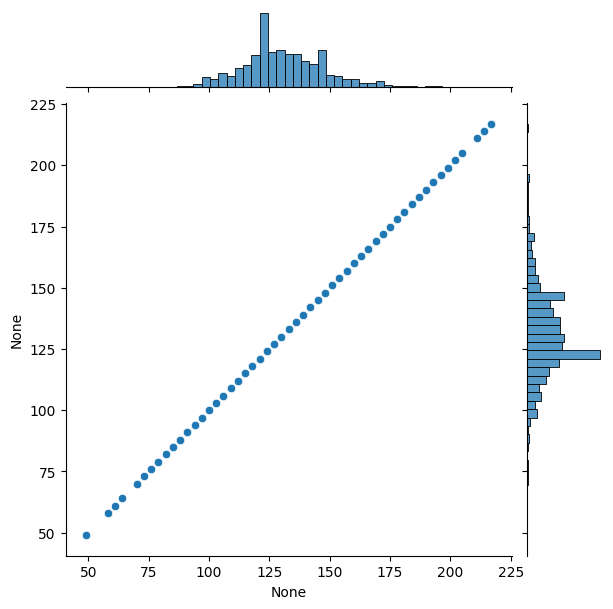

In [ ]:
sns.jointplot(y=dim1, x=dim2);

In [ ]:
# Nous observons que nos images n'ont pas toutes les mêmes dimensions
np.mean(dim1), np.mean(dim2)

(np.float64(130.8376923076923), np.float64(130.8376923076923))

In [ ]:
image_shape = (130, 130, 3) # Pour que toutes les images aient cette taille

## Image Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.legacy.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |
 |  DEPRECATED.
 |
 |  Methods defined here:
 |
 |  __init__(self, featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=

In [ ]:
imread(para_cell).max(), imread(uninfected_cell_path).max()

(np.float32(0.9019608), np.float32(0.9137255))

In [ ]:
image_gen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,
                               height_shift_range = 0.1, shear_range=0.1,
                               zoom_range=0.1, horizontal_flip = True,
                               fill_mode = 'nearest')

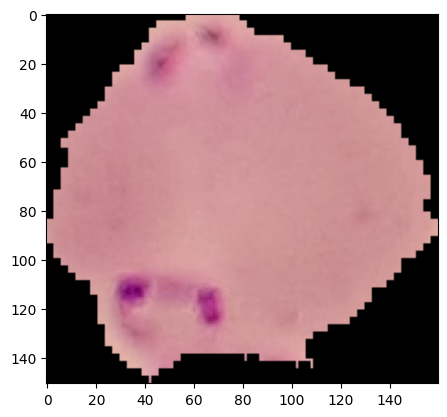

In [ ]:
plt.imshow(imread(para_cell));

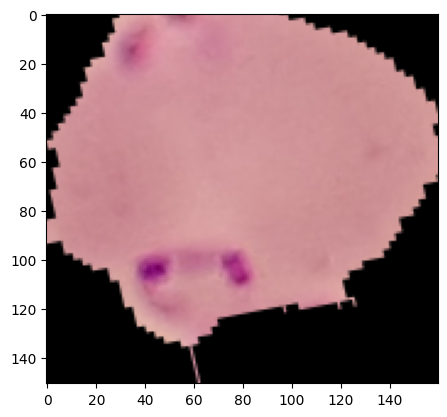

In [ ]:
plt.imshow(image_gen.random_transform(imread(para_cell)));

In [ ]:
batch_size = 16 # c'est toujours courant de choisir une puissance de 2

In [ ]:
train_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2],
                                          color_mode='rgb', batch_size=batch_size, class_mode = 'binary')
test_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2],
                                         color_mode='rgb', batch_size=batch_size,
                                         class_mode = 'binary', shuffle=False) # Il faut pas melanger les images test

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

## Modelisation

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential([
    Input(shape=image_shape),
    Conv2D(filters=32, kernel_size = (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(filters=64, kernel_size = (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(filters=64, kernel_size = (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,209 (6.34 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop = EarlyStopping(monitor='val_loss', patience=4)
save = ModelCheckpoint(filepath='best_model.keras', monitor = 'val_loss', save_best_only=True)

In [ ]:
h = model.fit(train_gen, epochs=25, validation_data = test_gen, callbacks=[stop, save])

Epoch 1/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 146s 91ms/step - accuracy: 0.5711 - loss: 0.6808 - val_accuracy: 0.5792 - val_loss: 0.6784
Epoch 2/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 141s 91ms/step - accuracy: 0.5816 - loss: 0.6793 - val_accuracy: 0.5704 - val_loss: 0.6784
Epoch 3/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.5822 - loss: 0.6750 - val_accuracy: 0.8546 - val_loss: 0.7461
Epoch 4/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - accuracy: 0.8584 - loss: 0.3749 - val_accuracy: 0.9404 - val_loss: 0.1868
Epoch 5/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.9364 - loss: 0.2012 - val_accuracy: 0.9338 - val_loss: 0.2039
Epoch 6/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.9418 - loss: 0.1863 - val_accuracy: 0.9404 - val_loss: 0.1871
Epoch 7/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 141s 91ms/step - accuracy: 0.9418 - loss: 0.1858 - val_accuracy: 0.9396 - val_loss: 0.1911
Epoch 8/25
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - accuracy: 

<Axes: >

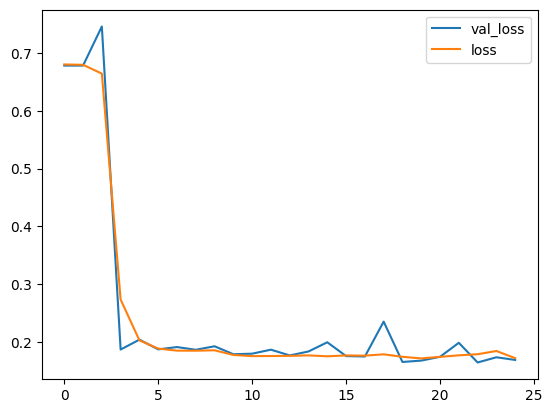

In [ ]:
losses = pd.DataFrame(h.history)
losses[['val_loss', 'loss']].plot()

<Axes: >

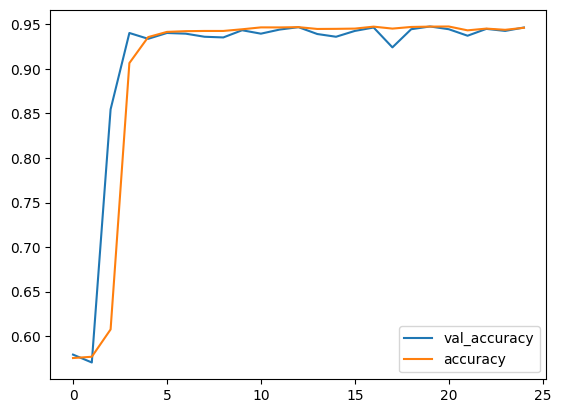

In [ ]:
losses[['val_accuracy', 'accuracy']].plot()

In [ ]:
final_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,986,629 (19.02 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,324,420 (12.68 MB)

In [ ]:
final_model.evaluate(test_gen)

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9401 - loss: 0.1688


[0.16132883727550507, 0.947692334651947]

In [ ]:
pred = model.predict(test_gen)

163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step


In [ ]:
predictions = pred > 0.5

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# les vrais classes
test_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
print(classification_report(test_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1300
           1       0.93      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



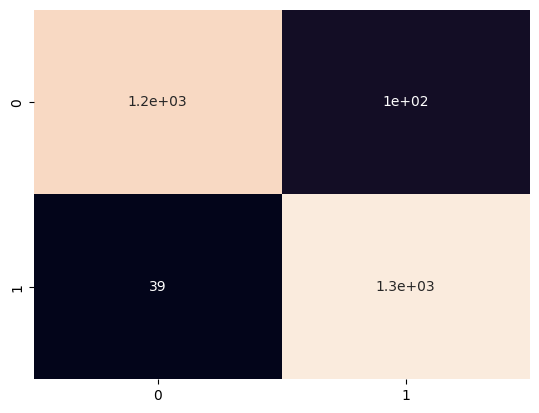

In [ ]:
sns.heatmap(confusion_matrix(test_gen.classes, predictions),annot=True, cbar=False);

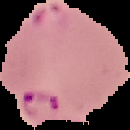

In [ ]:
my_img = tf.keras.preprocessing.image.load_img(para_cell, target_size=image_shape) # qui permet de lire des images
my_img

In [ ]:
my_img_array = tf.keras.preprocessing.image.img_to_array(my_img)
my_img_array.shape

(130, 130, 3)

In [ ]:
# ajoutons (1,130,130,3)
my_img_array = np.expand_dims(my_img_array, axis=0)
my_img_array.shape

(1, 130, 130, 3)

In [ ]:
(final_model.predict(my_img_array) > 0.5).astype('int32')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


array([[0]], dtype=int32)

In [ ]:
train_gen.class_indices

{'parasitized': 0, 'uninfected': 1}